In [1]:
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import active_contour
import skimage.io as io 
import scipy

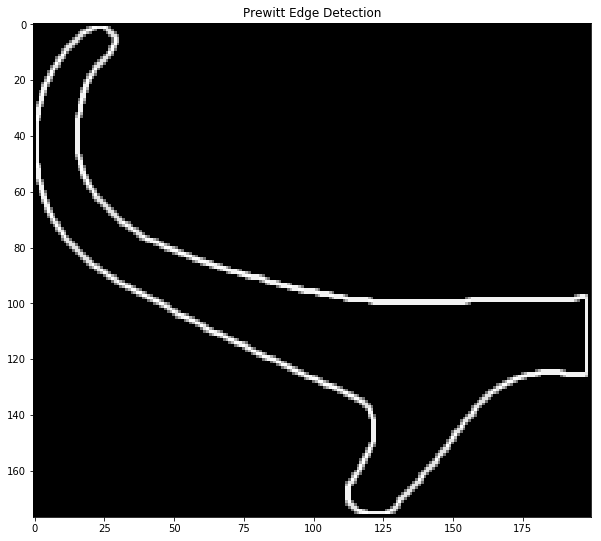

In [2]:
from skimage.filters import prewitt

img = io.imread('data/perfiles_CATA/png/AL_06E.png', as_grey=True)
edge_prewitt = prewitt(img)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

ax.imshow(edge_prewitt, cmap=plt.cm.gray)
ax.set_title('Prewitt Edge Detection')

In [3]:
x = ['x'+ str(x) for x in range(100)]
y = ['y'+ str(y) for y in range(100)]

columns = ['id'] + list(sum(zip(x, y), ()))

In [4]:
def interpcurve(N, pX, pY):
    #equally spaced in arclength
    N = np.transpose(np.linspace(0, 1, N))
    #how many points will be uniformly interpolated?
    nt = N.size

    #number of points on the curve
    n = pX.size
    pxy = np.array((pX, pY)).T
    p1 = pxy[0,:]
    pend = pxy[-1,:]
    last_segment = np.linalg.norm(np.subtract(p1, pend))
    epsilon= 10 * np.finfo(float).eps

    #IF the two end points are not close enough lets close the curve
    if last_segment > epsilon * np.linalg.norm(np.amax(abs(pxy), axis=0)):
        pxy = np.vstack((pxy, p1))
        nt = nt + 1

    pt = np.zeros((nt, 2))

    #Compute the chordal arclength of each segment.
    chordlen = (np.sum(np.diff(pxy, axis=0) ** 2, axis=1)) ** (1 / 2)
    #Normalize the arclengths to a unit total
    chordlen = chordlen / np.sum(chordlen)
    #cumulative arclength
    cumarc = np.append(0, np.cumsum(chordlen))

    tbins= np.digitize(N, cumarc) # bin index in which each N is in

    #catch any problems at the ends
    tbins[np.where(tbins<=0 | (N<=0))]=1
    tbins[np.where(tbins >= n | (N >= 1))] = n - 1      

    s = np.divide((N - cumarc[tbins]), chordlen[tbins-1])
    pt = pxy[tbins,:] + np.multiply((pxy[tbins,:] - pxy[tbins-1,:]), (np.vstack([s]*2)).T)

    return pt 

1192


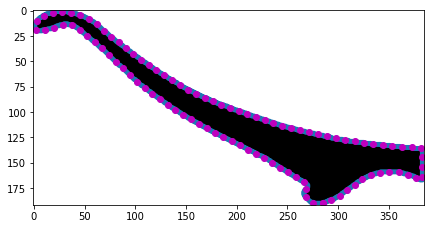

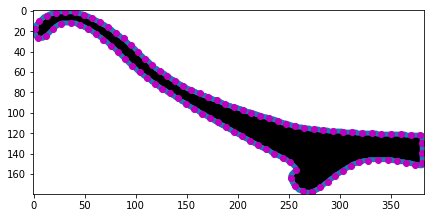

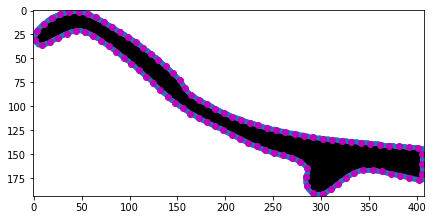

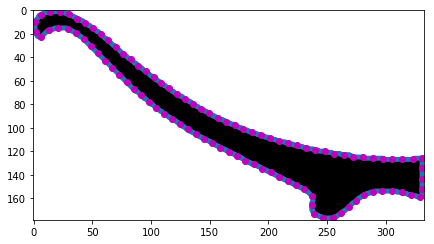

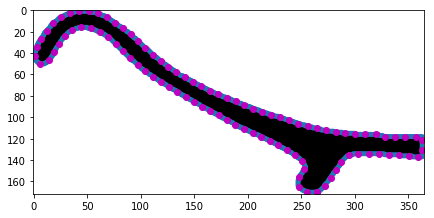

In [7]:
from skimage import measure
import pandas as pd
from os.path import basename

df_semilandmarks = pd.DataFrame(columns=columns)
collection = io.ImageCollection('data/perfiles_CATA/png/*.png')
print(len(collection))
counter = 0
for index, img in enumerate(collection):
    id_name = basename(collection.files[index])
    if img.ndim == 2:
        contours = measure.find_contours(img, 0.8)
        counter+=1
        fig = plt.figure(figsize=(7, 7))
        ax = fig.add_subplot(111)
        ax.imshow(img, interpolation='nearest', cmap=plt.cm.gray)

        # for n, contour in enumerate(contours):
        #print(contours[0].shape)
        contour = contours[0]
        ax.plot(contour[:, 1], contour[:, 0], linewidth=5)
        # resample_contour = contour[np.random.choice(contour.shape[0], 150, replace=False), :]
        resample_contour = interpcurve(100,  contour[:, 0],  contour[:, 1])
        # print(resample_contour[:4, 0], resample_contour[:4, 1], resample_contour[:4].ravel())
        df_semilandmarks.loc[index] = [id_name] + list(resample_contour.ravel())
        ax.plot(resample_contour[:, 1], resample_contour[:, 0], 'om', linewidth=5)
        plt.savefig('output/landmarked_'+id_name)
        plt.show()
    # To only show the first three on this ipynb
    if counter == 5:
        break

In [8]:
df_semilandmarks

,id,x0,y0,x1,y1,x2,y2,x3,y3,x4,...,x95,y95,x96,y96,x97,y97,x98,y98,x99,y99
0,AL_03A.png,190.0,285.003137,186.634417,293.368721,182.561727,301.441411,177.074823,308.928314,171.587919,...,169.003137,266.179026,175.909525,268.087338,183.982215,267.979077,189.469118,275.465981,190.0,285.003137
1,AL_03B.png,178.0,273.003137,173.249070,280.754067,167.791034,288.212103,161.625891,295.377246,156.874962,...,156.245197,256.751666,163.994522,251.996863,172.039949,256.036812,177.003137,263.699821,178.0,273.003137
2,AL_03C.png,192.0,302.003137,186.765535,310.237603,180.823962,318.179175,174.882390,326.120747,170.003137,...,164.954615,284.996863,174.114626,283.996863,183.779984,285.776847,191.014450,292.011312,192.0,302.003137
3,AL_03D.png,177.0,255.003137,173.034324,261.968813,167.654435,268.348702,162.274545,274.728592,157.601763,...,157.921746,236.918609,165.669217,236.996863,173.317564,239.314426,176.576133,246.572995,177.0,255.003137
4,AL_03E.png,170.0,265.003137,163.928069,272.003137,156.605380,277.397757,149.261624,282.741513,141.624974,...,148.750585,252.996863,156.236730,247.996863,164.975616,247.972479,169.612266,255.609128,170.0,265.003137


In [15]:
df_semilandmarks.to_csv("data/input_morphoJ.csv", index=None)